# import所需物件

In [154]:
%matplotlib inline
from matplotlib.font_manager import FontProperties
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, KFold , GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

# 載入數據

In [155]:
#載入數據
df_train = pd.read_csv("https://kaggle-getting-started.s3-ap-northeast-1.amazonaws.com/titanic/train.csv")
df_train['Group']=int(1)#train
df_test = pd.read_csv("https://kaggle-getting-started.s3-ap-northeast-1.amazonaws.com/titanic/test.csv")
df_test['Group']=int(2)#test
df_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Group
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,1
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,1


In [156]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Group
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,2
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,2
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,2
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,2
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,2
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,2


# 數據代號名稱

PassengerId 旅客編號

Survived 倖存下來

Pclass 票務艙等

Name 名稱

Sex 性別

Age 年齡

SibSp 船上的兄弟姐妹配偶人數

Parch 船上的父母子女人數

Ticket 票號

Fare 乘客票價

Cabin艙

Embarked 登船港口

# 解釋代號與數據關聯性(畫圖)

Text(0.5, 1.0, '票務艙等的存活率')

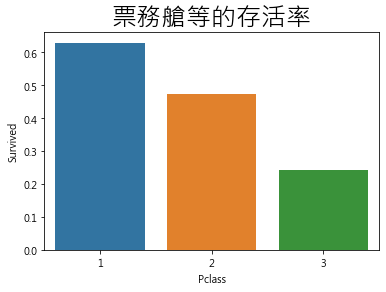

In [157]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.barplot(x="Pclass", y="Survived", data=df_train,ci=0)
plt.title('票務艙等的存活率',fontsize=25)

Text(0.5, 1.0, '票務艙等的存活與非存活總和')

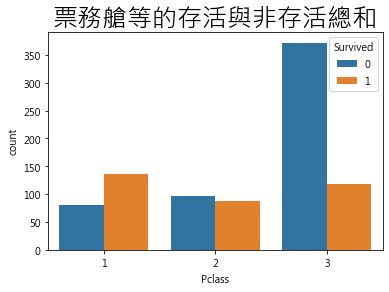

In [158]:
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.countplot(x="Pclass",hue="Survived",data=df_train) 
plt.title('票務艙等的存活與非存活總和',fontsize=25)

Text(0.5, 1.0, 'Sex v.s. Survived')

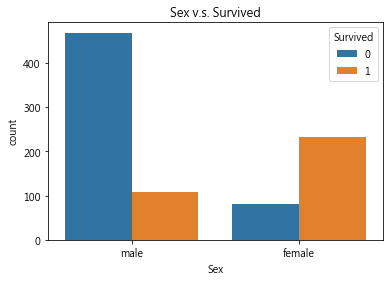

In [159]:

sns.countplot(x="Sex",hue="Survived",data=df_train) 
plt.title("Sex v.s. Survived")


In [160]:
def cat_analysis(df, feature, x, y, figsize=(8,5), rotation="45", palette=None, order=None):
    
    data = (pd.DataFrame(df[feature].value_counts())
                .reset_index()
                .rename(columns={'index': x, feature: y}))
    
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(x=x, y=y, data=data, palette=palette, order=order);
    plt.xticks(rotation=rotation)
    plt.title(f"Distribution of {feature}")
    plt.show()

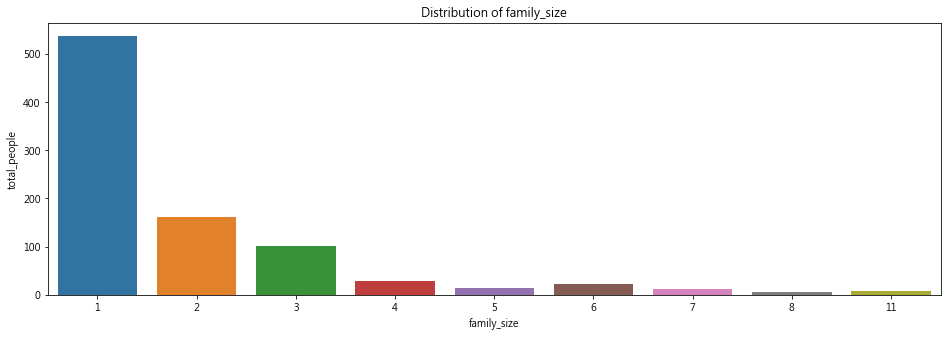

In [161]:
df_train["family_size"] = 1 + df_train["SibSp"] + df_train["Parch"]

# Distribution
cat_analysis(df_train, "family_size", "family_size", "total_people", rotation=0, figsize=(16,5))
# Let's drop it for now
df_train.drop(["family_size"], axis=1, inplace=True)

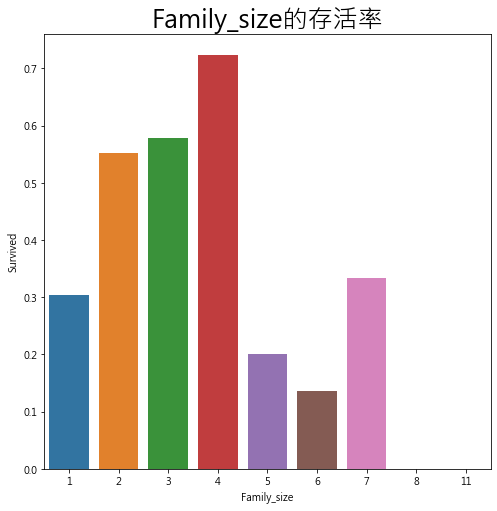

In [162]:
plt.figure(figsize=(8,8))
df_train["Family_size"] = 1 + df_train["SibSp"] + df_train["Parch"]
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.barplot(x="Family_size", y="Survived", data=df_train,ci=0)
plt.title('Family_size的存活率',fontsize=25)
df_train.drop(["Family_size"], axis=1, inplace=True)

# 特徵工程

In [163]:
df_train.shape , df_test.shape

((891, 13), (418, 12))

In [164]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  Group        891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [165]:
df_train["Age"].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

可發現有nan(遺失值)的部分 

In [166]:
df_train.isnull( ).sum( )

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Group            0
dtype: int64

年齡 (Age) 跟幾號艙 (Cabin) 遺失值很多

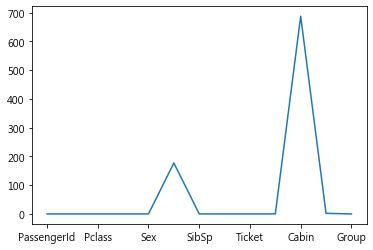

In [167]:
#用圖呈現遺失值
df_train.isnull( ).sum( ).plot( )

train["Age"]的中位數 ： 28.0
train["Age"]的平均數 ： 29.69911764705882


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


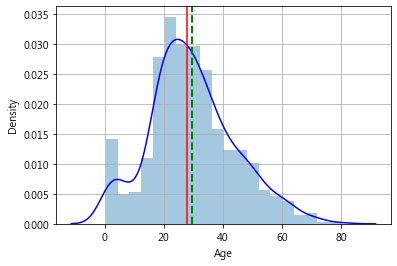

In [168]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df_train["Age"],
            kde_kws={"color": "b"})
plt.axvline(df_train["Age"].median(), color='red')
plt.axvline(df_train["Age"].mean(), color='green', linestyle='dashed', linewidth=2)
plt.grid()
print('train["Age"]的中位數 ：',df_train["Age"].median())
print('train["Age"]的平均數 ：',df_train["Age"].mean())



# 合併train跟test

In [169]:
df_data = df_train.append( df_test )
df_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Group
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,2
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,2
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,2
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,2


In [170]:
#再次看遺失值
df_data.isnull( ).sum( )

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
Group             0
dtype: int64

In [171]:
#刪除Cabin，遺失值過多無法填補適當值
df_data = df_data.drop(['Cabin'],axis = 1)

In [172]:
# 擷取出稱謂(Title)的資訊
import re
regex = re.compile( ' ([A-Za-z]+)\.' )  
df_data['Title'] = df_data.Name.map( lambda x:regex.search(x)[0] )
# Dropping the first and the last words
df_data['Title'] = df_data.Title.map( lambda x:x[1:][:-1] )  
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer', 'Dona'], dtype=object)

In [173]:
#確認是不是1309 全數據都有
df_data['Title'].count()

1309

In [174]:
# 將同樣性別或關係的稱謂合併
df_data['Title'] = df_data.Title.replace( ['Don','Lady','Sir','Countess','Jonkheer','Dona'], 'Rare' )
df_data['Title'] = df_data.Title.replace(['Capt','Col','Major','Rev','Dr'] ,'Army'  )
df_data['Title'] = df_data.Title.replace( ['Ms','Mme','Mrs'], 'Mrs' )
df_data['Title'] = df_data.Title.replace(['Mlle','Miss'] , 'Miss' )
df_data['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Rare', 'Army'], dtype=object)

In [175]:
# 計算每個 Title 的年齡平均值及中位數
Age_Mean = df_data[['Title','Age']].groupby( by=['Title'] ).mean()
Age_Median = df_data[['Title','Age']].groupby( by=['Title'] ).median()

Age_Mean.columns = ['Age Mean']
Age_Median.columns = ['Age Median']
Age_Mean.reset_index( inplace=True )
Age_Median.reset_index( inplace=True )

display( Age_Median )
display( Age_Mean )

,Title,Age Median
0,Army,49.5
1,Master,4.0
2,Miss,22.0
3,Mr,29.0
4,Mrs,35.0
5,Rare,39.5


,Title,Age Mean
0,Army,46.272727
1,Master,5.482642
2,Miss,21.795236
3,Mr,32.252151
4,Mrs,36.866279
5,Rare,41.166667


In [176]:
# 利用每個 Title 的年齡平均數，填補每個 Title 所對應 Age 的缺漏值
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Army'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Army','Age Mean'][0]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Master'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Master','Age Mean'][1]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Miss'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Miss','Age Mean'][2]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mr'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mr','Age Mean'][3]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Mrs'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Mrs','Age Mean'][4]
df_data.loc[(df_data.Age.isnull())&(df_data.Title=='Rare'),'Age'] = Age_Mean.loc[Age_Mean.Title=='Rare','Age Mean'][5]

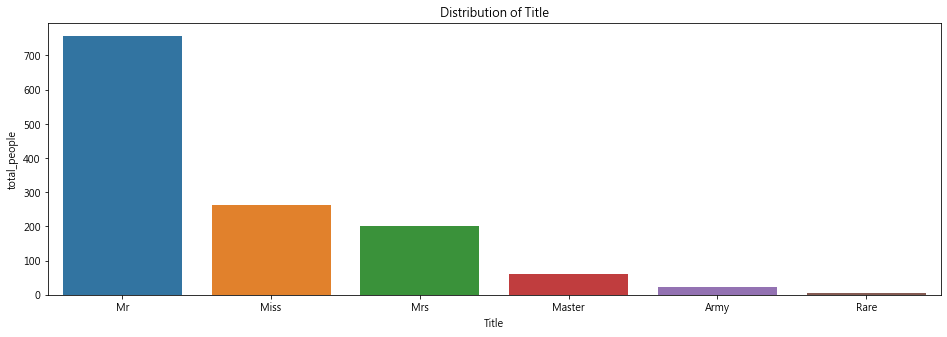

,Title,Survival Rate(%)
0,Army,27.777778
1,Master,57.500000
2,Miss,70.108696
3,Mr,15.667311
4,Mrs,79.527559
5,Rare,60.000000


In [177]:
cat_analysis(df_data, "Title", "Title", "total_people", rotation=0, figsize=(16,5))
Survival_Rate = df_data[['Title','Survived']].groupby(by=['Title']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

In [178]:
Title_category = {'Mr':1, 'Mrs':2, 'Miss':3, 'Master':4, 'Rare':5,'Army':6}
# Mapping 'Title' to group
df_data['Title'] = df_data['Title'].map(Title_category)
df_data['Title'].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

train["Fare"]的中位數 ： 14.4542
train["Fare"]的平均數 ： 32.2042079685746
train["Fare"]的最小值 ： 0.0
train["Fare"]的最大值 ： 512.3292


C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


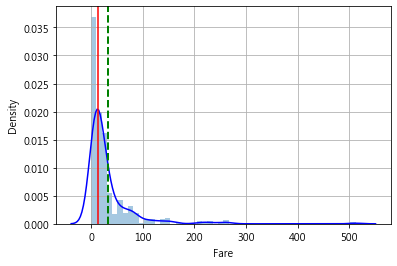

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.distplot(df_train["Fare"],
            kde_kws={"color": "b"})
plt.axvline(df_train["Fare"].median(), color='red')
plt.axvline(df_train["Fare"].mean(), color='green', linestyle='dashed', linewidth=2)
plt.grid()
print('train["Fare"]的中位數 ：',df_train["Fare"].median())
print('train["Fare"]的平均數 ：',df_train["Fare"].mean())
print('train["Fare"]的最小值 ：',df_train["Fare"].min())
print('train["Fare"]的最大值 ：',df_train["Fare"].max())



In [180]:
Pclass_Fare = df_data[['Pclass','Fare']].groupby( by=['Pclass'] ).mean()
Pclass_Fare
Pclass_Fare.columns = ['Fare Mean']
Pclass_Fare.reset_index( inplace=True )
Pclass_Fare

,Pclass,Fare Mean
0,1,87.508992
1,2,21.179196
2,3,13.302889


In [181]:
# 利用每個 艙等 的票價平均數，填補每個 Pclass 所對應 Fare 的 0或缺漏值
df_data.loc[(df_data.Fare.isnull())&(df_data.Pclass==3),'Fare'] = Pclass_Fare.loc[Pclass_Fare.Pclass==3,'Fare Mean'][2]
df_data.loc[(df_data.Fare<=0)&(df_data.Pclass==1),'Fare'] = Pclass_Fare.loc[Pclass_Fare.Pclass==1,'Fare Mean'][0]
df_data.loc[(df_data.Fare<=0)&(df_data.Pclass==2),'Fare'] = Pclass_Fare.loc[Pclass_Fare.Pclass==2,'Fare Mean'][1]
df_data.loc[(df_data.Fare<=0)&(df_data.Pclass==3),'Fare'] = Pclass_Fare.loc[Pclass_Fare.Pclass==3,'Fare Mean'][2]

Text(0.5, 1.0, '登船港口的總和')

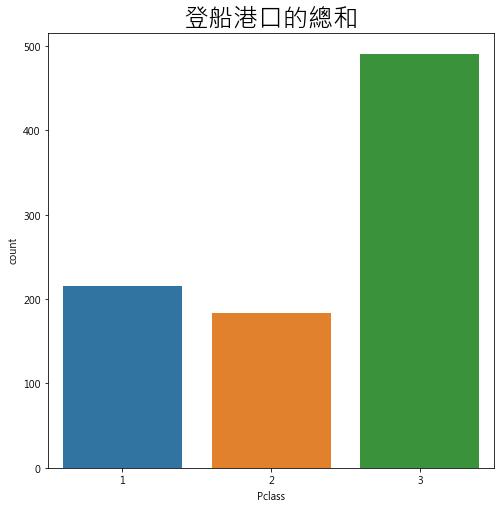

In [182]:
plt.figure(figsize=(8,8))
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
sns.countplot(x="Pclass",data=df_train) 
plt.title('登船港口的總和',fontsize=25)

In [183]:
#取眾數(出現次數最多)
df_data.loc[(df_data.Embarked.isnull())] = 'Q'

In [184]:
df_data['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [185]:
Embarked_category = {'S':1, 'C':2, 'Q':3}
# Mapping 'Embarked' to group
df_data['Embarked'] = df_data['Embarked'].map(Embarked_category)
df_data['Embarked'].unique()

array([1, 2, 3], dtype=int64)

In [186]:
df_data.isnull( ).sum( )

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Group            0
Title            0
dtype: int64

In [187]:
# Label Encoding
Sex_mapping = { 'male':0, 'female':1 }
df_data[ 'Sex' ] = df_data.Sex.map( Sex_mapping )

# 遺失值填補完，加數據

In [188]:
# 假設 Ticket 中，前面英文字母的部份代表房間位於相同的區域
df_data['Ticket_info'] = df_data.Ticket.apply( lambda x:x.replace('.','').replace('/','').strip().split(' ')[0] if not x.isdigit() else 'X')
df_data['Ticket_info'].unique()
# 類別型態欄位轉為整數
for col in ['Ticket_info']:
    df_data[col] = df_data[col].astype('category').cat.codes



In [189]:
df_data['Age_Leavel'] = np.nan
df_data.loc[(df_data.Age>=0) & (df_data.Age<=19), 'Age_Leavel'] = 1
df_data.loc[(df_data.Age>=20) & (df_data.Age<=39), 'Age_Leavel'] = 2
df_data.loc[(df_data.Age>=40) & (df_data.Age<=59), 'Age_Leavel'] = 3
df_data.loc[(df_data.Age>=60) , 'Age_Leavel'] = 4
df_data['Age_Leavel']

TypeError: '>=' not supported between instances of 'str' and 'int'

In [190]:
Survival_Rate = df_data[['Sex','Age_Leavel','Survived']].groupby(by=['Sex','Age_Leavel']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

DataError: No numeric types to aggregate

In [191]:
df_data[ 'Sex_Age' ] = np.nan
df_data.loc[ (df_data.Sex==0) & (df_data.Age_Leavel==1.0), 'Sex_Age' ] = 1
df_data.loc[ (df_data.Sex==0) & (df_data.Age_Leavel==2.0), 'Sex_Age' ] = 2
df_data.loc[ (df_data.Sex==0) & (df_data.Age_Leavel==3.0), 'Sex_Age' ] = 2
df_data.loc[ (df_data.Sex==0) & (df_data.Age_Leavel==4.0), 'Sex_Age' ] = 2
df_data.loc[ (df_data.Sex==1) & (df_data.Age_Leavel==1.0), 'Sex_Age' ] = 3
df_data.loc[ (df_data.Sex==1) & (df_data.Age_Leavel==2.0), 'Sex_Age' ] = 3
df_data.loc[ (df_data.Sex==1) & (df_data.Age_Leavel==3.0), 'Sex_Age' ] = 3
df_data.loc[ (df_data.Sex==1) & (df_data.Age_Leavel==4.0), 'Sex_Age' ] = 4
df_data[ 'Sex_Age' ] 


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
413   NaN
414   NaN
415   NaN
416   NaN
417   NaN
Name: Sex_Age, Length: 1309, dtype: float64

# Sex

In [109]:
# Sex & Pclass 
import numpy as np
Survival_Rate = df_data[['Sex','Pclass','Survived']].groupby(by=['Sex','Pclass']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

DataError: No numeric types to aggregate

In [110]:
# 依據在不同艙等中的男女性生存率，給予不同的生存率級別(6最高、1最小)：
df_data[ 'Sex_Pclass' ] = np.nan
df_data.loc[ (df_data.Sex==1) & (df_data.Pclass==1), 'Sex_Pclass' ] = 6
df_data.loc[ (df_data.Sex==1) & (df_data.Pclass==2), 'Sex_Pclass' ] = 5
df_data.loc[ (df_data.Sex==1) & (df_data.Pclass==3), 'Sex_Pclass' ] = 4
df_data.loc[ (df_data.Sex==0) & (df_data.Pclass==1), 'Sex_Pclass' ] = 3
df_data.loc[ (df_data.Sex==0) & (df_data.Pclass==2), 'Sex_Pclass' ] = 2
df_data.loc[ (df_data.Sex==0) & (df_data.Pclass==3), 'Sex_Pclass' ] = 1

In [111]:
import numpy as np
Survival_Rate = df_data[['Sex','Ticket_info','Survived']].groupby(by=['Sex','Ticket_info']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

DataError: No numeric types to aggregate

In [112]:
df_data[ 'Sex_Ticket_info' ] = np.nan
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==1), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==5), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==8), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==9), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==10), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==11), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==15), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==16), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==19), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==20), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==21), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==23), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==24), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==25), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==26), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==27), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==29), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==31), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==34), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==35), 'Sex_Ticket_info' ] = 0
# ------------------------------------------------------------------------
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==33), 'Sex_Ticket_info' ] = 1
# -------------------------------------------------------
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==2), 'Sex_Ticket_info' ] = 2
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==6), 'Sex_Ticket_info' ] = 3
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==7), 'Sex_Ticket_info' ] = 4
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==12), 'Sex_Ticket_info' ] =5
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==14), 'Sex_Ticket_info' ] = 6
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==22), 'Sex_Ticket_info' ] = 7
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==28), 'Sex_Ticket_info' ] = 8
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==30), 'Sex_Ticket_info' ] = 9
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==36), 'Sex_Ticket_info' ] = 10
# ----------------------------------------------------------------
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==2), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==26), 'Sex_Ticket_info' ] = 0
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==28), 'Sex_Ticket_info' ] = 0
# ----------------------------------------------------------------------------
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==6), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==10), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==15), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==16), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==17), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==20), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==22), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==23), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==24), 'Sex_Ticket_info' ] = 1
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==35), 'Sex_Ticket_info' ] = 1
# ---------------------------------------------------------------------------------
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==7), 'Sex_Ticket_info' ] = 11
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==14), 'Sex_Ticket_info' ] = 12
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==31), 'Sex_Ticket_info' ] = 13
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==34), 'Sex_Ticket_info' ] = 14
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==36), 'Sex_Ticket_info' ] = 15
# -----------------------------------------------------------------------------
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==4), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==13), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==17), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==18), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==0) & (df_data.Ticket_info==32), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==0), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==1), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==3), 'Sex_Ticket_info' ] = 16
df_data.loc[ (df_data.Sex==1) & (df_data.Ticket_info==9), 'Sex_Ticket_info' ] = 16

In [113]:
df_data['Family_size'] = df_data['SibSp'] + df_data['Parch'] + 1
Survival_Rate = df_data[['Family_size','Survived']].groupby(by=['Family_size']).agg(np.mean)*100
cat_analysis(df_data, "Family_size", "Family_size", "total_people", rotation=0, figsize=(16,5))
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()
# df_data

TypeError: can only concatenate str (not "int") to str

In [114]:
# 創造新的特徵變數：家庭人數獲救等級(Family_Class)
df_data[ 'Family_Class' ] = np.nan
df_data.loc[ (df_data.Family_size>=2) & (df_data.Family_size<=4), 'Family_Class' ] = 3
df_data.loc[ (df_data.Family_size==1) , 'Family_Class' ] = 2
df_data.loc[ (df_data.Family_size>=5) & (df_data.Family_size<=7), 'Family_Class' ] = 1
df_data.loc[ (df_data.Family_size>=8), 'Family_Class' ] = 0
df_data[ 'Family_Class' ] 

AttributeError: 'DataFrame' object has no attribute 'Family_size'

In [115]:
# Sex & Pclass 
import numpy as np
Survival_Rate = df_data[['Sex','Family_size','Survived']].groupby(by=['Sex','Family_size']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

KeyError: "['Family_size'] not in index"

In [116]:
df_data[ 'Sex_Family_size' ] = np.nan
df_data.loc[ (df_data.Family_size>=8) & (df_data.Family_size<=11), 'Sex_Family_size' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Family_size==5), 'Sex_Family_size' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Family_size==6), 'Sex_Family_size' ] = 0
df_data.loc[ (df_data.Sex==0) & (df_data.Family_size==1), 'Sex_Family_size' ] = 1
df_data.loc[ (df_data.Sex==0) & (df_data.Family_size==2), 'Sex_Family_size' ] = 2
df_data.loc[ (df_data.Sex==0) & (df_data.Family_size==3), 'Sex_Family_size' ] = 3
df_data.loc[ (df_data.Sex==0) & (df_data.Family_size==4), 'Sex_Family_size' ] = 4
df_data.loc[ (df_data.Sex==0) & (df_data.Family_size==7), 'Sex_Family_size' ] = 5
df_data.loc[ (df_data.Sex==1) & (df_data.Family_size==1), 'Sex_Family_size' ] = 6
df_data.loc[ (df_data.Sex==1) & (df_data.Family_size==2), 'Sex_Family_size' ] = 7
df_data.loc[ (df_data.Sex==1) & (df_data.Family_size==3), 'Sex_Family_size' ] = 8
df_data.loc[ (df_data.Sex==1) & (df_data.Family_size==4), 'Sex_Family_size' ] = 9
df_data.loc[ (df_data.Sex==1) & (df_data.Family_size==5), 'Sex_Family_size' ] = 10
df_data.loc[ (df_data.Sex==1) & (df_data.Family_size==6), 'Sex_Family_size' ] = 11
df_data.loc[ (df_data.Sex==1) & (df_data.Family_size==7), 'Sex_Family_size' ] = 12


AttributeError: 'DataFrame' object has no attribute 'Family_size'

In [ ]:
# Sex & Pclass 
import numpy as np
Survival_Rate = df_data[['Sex','Family_Class','Survived']].groupby(by=['Sex','Family_Class']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

In [ ]:
df_data[ 'Sex_Family_Class' ] = np.nan
df_data.loc[ (df_data.Sex ==0) & (df_data.Family_Class==0), 'Sex_Family_Class' ] = 0
df_data.loc[ (df_data.Sex ==1) & (df_data.Family_Class==0), 'Sex_Family_Class' ] = 0
df_data.loc[ (df_data.Sex ==0) & (df_data.Family_Class==1), 'Sex_Family_Class' ] = 1
df_data.loc[ (df_data.Sex ==0) & (df_data.Family_Class==2), 'Sex_Family_Class' ] = 2
df_data.loc[ (df_data.Sex ==0) & (df_data.Family_Class==3), 'Sex_Family_Class' ] = 3
df_data.loc[ (df_data.Sex ==1) & (df_data.Family_Class==1), 'Sex_Family_Class' ] = 3
df_data.loc[ (df_data.Sex ==1) & (df_data.Family_Class==2), 'Sex_Family_Class' ] = 4
df_data.loc[ (df_data.Sex ==1) & (df_data.Family_Class==3), 'Sex_Family_Class' ] = 4



In [ ]:
# Sex & Pclass 
import numpy as np
Survival_Rate = df_data[['Sex','Embarked','Survived']].groupby(by=['Sex','Embarked']).agg(np.mean)*100
Survival_Rate.columns = ['Survival Rate(%)']
Survival_Rate.reset_index()

In [ ]:
df_data[ 'Sex_Embarked' ] = np.nan
df_data.loc[ (df_data.Sex==0) & (df_data.Embarked==1), 'Sex_Embarked' ] = 1
df_data.loc[ (df_data.Sex==0) & (df_data.Embarked==2), 'Sex_Embarked' ] = 2
df_data.loc[ (df_data.Sex==0) & (df_data.Embarked==3), 'Sex_Embarked' ] = 3
df_data.loc[ (df_data.Sex==1) & (df_data.Embarked==1), 'Sex_Embarked' ] = 4
df_data.loc[ (df_data.Sex==1) & (df_data.Embarked==2), 'Sex_Embarked' ] = 5
df_data.loc[ (df_data.Sex==1) & (df_data.Embarked==3), 'Sex_Embarked' ] = 6

In [ ]:
df_data.isnull( ).sum( )

# 產生訓練集和測試集

In [ ]:
# 產生訓練集和測試集
Train = df_data[df_data.Group==int(1) ]
Test = df_data[df_data.Group==int(2) ]
# 訓練集刪除 PassengerId , Name , Ticket欄位；
# 測試集刪除 PassengerId , Name , Ticket欄位;
Train.drop( ['PassengerId','Name' , 'Ticket' ], axis=1, inplace=True )
Test.drop( ['Name' , 'Ticket'  ], axis=1, inplace=True )
# 將測試集中的標籤欄位 Survived 單獨拆出
Y_Train = Train.Survived
X_Train = Train.drop( ['Survived'], axis=1 )
X_Test = Test

X_Train.shape , Y_Train.shape , X_Test.shape

# 特徵重要性

In [ ]:
params = {
 'learning_rate': [0.01, 0.05, 0.1],
 'subsample': [1],
 'colsample_bylevel': [1],
 'colsample_bynode': [1],
 'colsample_bytree': [0.5],
 'gamma': [0, 1, 2],
 'max_delta_step': [0],
 'max_depth': [2, 3, 4],
 'min_child_weight': [1.6], # Owen Zhang's rule of thumb: mcw = 3/sqrt(event_rate) -> 1.6 (Thanks Tae Hyon Whang)
 'n_estimators': [100],
 'random_state': [42],
 'scale_pos_weight': [1],
 'seed': [42],
 'n_jobs': [-1],
 'reg_lambda': [1, 2, 4, 16]
}

In [ ]:
def my_xgb(data, target, params):
    
    X= data
    y = target
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    
    # Create a XGBoost classifier (scikit-learn API wrapper)
    xgb_clf = xgb.XGBClassifier()
    
    # Perform a gridsearch with sklearn
    kf = KFold(n_splits=10, random_state=42, shuffle=True)
    gridsearch = GridSearchCV(xgb_clf, param_grid=params, scoring="accuracy", cv=kf, return_train_score=True)
    gridsearch.fit(X_scaled, y)
    
    # Return the gridsearch results plus the scaler
    return gridsearch, scaler

In [ ]:
gridsearch, scaler = my_xgb(X_Train, Y_Train, params)

In [ ]:
feature_importances = gridsearch.best_estimator_.feature_importances_
feature_names = X_Train.columns

temp_df1 = {
    'feature_name': feature_names,
    'feature_importance': feature_importances
}

temp_df1 = pd.DataFrame(temp_df1).sort_values(by="feature_importance", ascending=False)

display(temp_df1.reset_index(drop=True))

In [ ]:
# xgbc = XGBClassifier(
#         objective = 'binary:logistic',
#         max_depth=4,
#         n_estimators= 5,)
# xgbc.fit(X_Train, Y_Train)
# print(xgbc.score(X_Train, Y_Train))
# # 特徵重要性
# xgbc.feature_importances_
# # 特徵重要性圖
# import xgboost
# xgboost.plot_importance(xgbc)

In [ ]:
new_clf = SelectKBest(chi2,k=6).fit(X_Train,Y_Train)
a = pd.DataFrame(new_clf.get_support()  ,  X_Train.keys() ,columns=['rank'])
a

In [ ]:
# clos = ['Pclass','SibSp','Title','Sex_Pclass','Family_size','Family_Class','Sex_Family_size']
clos = ['Sex','Sex_Pclass','Title','Sex_Family_size','Sex_Ticket_info','Sex_Embarked','']
accuracy_1 = []
kfold =KFold(n_splits=5, shuffle=True)
for i in range(1,101,1):
    for j in range(1,5,1):
        xgbc = XGBClassifier(n_estimators = i,max_depth = j)
        xgbc.fit(X_Train[clos], Y_Train)
        accuracy_1.append(xgbc.score(X_Train[clos], Y_Train))

                

#         Kf_cv_scores = cross_val_score(xgbc,X_Train, Y_Train,cv=kfold)
#         accuracy_1.append(Kf_cv_scores.mean())

print(max(accuracy_1))
print(accuracy_1.index(max(accuracy_1)))

In [ ]:
# clos = ['Pclass','SibSp','Title','Sex_Pclass','Family_size','Family_Class','Sex_Family_size']
clos = ['Sex','Sex_Pclass','Title','Sex_Family_size','Sex_Ticket_info','Sex_Embarked','Sex_Age']
xgbc = XGBClassifier(n_estimators=88
                     ,objective = 'binary:logistic'
                     ,max_depth=4)

xgbc.fit(X_Train[clos], Y_Train)
print(xgbc.score(X_Train[clos], Y_Train))

In [ ]:

#設置Graphviz路徑

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


plt.rcParams["figure.figsize"] = (24, 24) #設定之後所有圖片大小

#XGB樹模型輸出
from xgboost import plot_tree

plot_tree(xgbc,num_trees=0)
plot_tree(xgbc,num_trees=1)
plt.show()

In [ ]:
true = pd.read_csv('submission.csv') #匯入準確值為1的Survived
y_true = true
y_true.drop( ['PassengerId'], axis=1, inplace=True )
#其他index
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = xgbc.predict( X_Test[clos])
cm = confusion_matrix(y_true,y_pred)
print(cm)
print(classification_report(y_true,y_pred))
print("Confusion matrix")
print(cm)


In [ ]:
# kfold- cross validataion
kfold =KFold(n_splits=5, shuffle=True)
Kf_cv_scores = cross_val_score(xgbc,X_Train, Y_Train,cv=kfold)
print(Kf_cv_scores)
print('mean of K fold=',Kf_cv_scores.mean())

In [ ]:
y_pred_xgbc = xgbc.predict( X_Test[clos])
answer = Test[['PassengerId']]
answer['Survived']=y_pred_xgbc.astype(int)
answer.to_csv('answer_xgbc_3.csv',index = False)
answer

# KNN(K-Nearest Neighbors)

In [ ]:
new_clf = SelectKBest(chi2,k=5).fit(X_Train,Y_Train)
a = pd.DataFrame(new_clf.get_support()  ,  X_Train.keys() ,columns=['rank'])
a

In [ ]:
# clos = ['Pclass','Sex','Age','Fare','Title','Sex_Pclass'
#         ,'Sex_Ticket_info','Family_Class','Sex_Family_size', 'Sex_Embarked']
clos = ['Sex','Sex_Pclass','Title','Sex_Family_size','Sex_Ticket_info','Sex_Embarked','Sex_Age']
#加入n ,把 accuracy 設為一個空的list
accuracy_2 = []
for n in range(1,51,1):
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_Train[clos], Y_Train)
    Kf_cv_scores = cross_val_score(clf,X_Train[clos], Y_Train,cv=kfold)
    accuracy_2.append(Kf_cv_scores.mean())
#     accuracy_2.append((clf.score(X_Train[clos], Y_Train)))

In [ ]:
print(max(accuracy_2))
print(accuracy_2.index(max(accuracy_2)))

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(range(1,51,1),accuracy_2, color='red',label='train')
plt.grid()
plt.show()

In [ ]:
clf = KNeighborsClassifier(n_neighbors=9)
clf.fit(X_Train[clos], Y_Train)
clf.score(X_Train[clos], Y_Train)

In [ ]:
true = pd.read_csv('submission.csv') #匯入準確值為1的Survived
y_true = true
y_true.drop( ['PassengerId'], axis=1, inplace=True )
#其他index
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = clf.predict( X_Test[clos])
table = classification_report(y_true,y_pred)
cm = confusion_matrix(y_true,y_pred)
print(table)
print("Confusion matrix")
print(cm)


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
kfold =KFold(n_splits=5, shuffle=True,random_state = 100)
Kf_cv_scores = cross_val_score(clf,X_Train[clos], Y_Train,cv=kfold)
print(Kf_cv_scores)
print('mean of K fold=',Kf_cv_scores.mean())

In [ ]:
y_pred_2 = clf.predict( X_Test[clos])
answer = Test[['PassengerId']]
answer['Survived']=y_pred_2.astype(int)
answer.to_csv('answer_KNN_1.csv',index = False)
answer

# 邏輯斯回歸分析LogisticRegression

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
selector = SelectFromModel(estimator=LogisticRegression()).fit(X_Train, Y_Train)
selector.estimator_.coef_

In [ ]:
selector.get_support() , X_Train.columns
a = pd.DataFrame(selector.get_support()  ,  X_Train.columns ,columns=['rank'])
a

In [ ]:
from sklearn.linear_model import LogisticRegression
clos = ['Pclass','SibSp','Title','Sex_Pclass','Family_size','Family_Class','Sex_Family_size']
Model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500,C=1.0)
Model.fit(X_Train[clos], Y_Train)

In [ ]:
print('coef', Model.coef_)
print('intercept', Model.intercept_)

In [ ]:
Model.score(X_Train[clos], Y_Train)

In [ ]:
true = pd.read_csv('submission.csv') #匯入準確值為1的Survived
y_true = true
y_true.drop( ['PassengerId'], axis=1, inplace=True )
#其他index
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = Model.predict( X_Test[clos])
cm = confusion_matrix(y_true,y_pred)
print(cm)
print(classification_report(y_true,y_pred))
print("Confusion matrix")
print(cm)


In [ ]:
from sklearn.model_selection import cross_val_score, KFold
kfold =KFold(n_splits=5, shuffle=True,random_state = 100)
Kf_cv_scores = cross_val_score(Model,X_Train[clos], Y_Train,cv=kfold)
print(Kf_cv_scores)
print('mean of K fold=',Kf_cv_scores.mean())

In [ ]:
y_pred_3 = Model.predict( X_Test[clos])
answer = Test[['PassengerId']]
answer['Survived']=y_pred_3.astype(int)
answer.to_csv('answer_LogisticRegression_1.csv',index = False)
answer